In [82]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import hashlib # Делать хеши
import swifter # Ускорение метода apply
from scipy import stats

%matplotlib inline

# Анализ результатов A/B-теста по оценке влияния новой функциональности

## Описание проекта

В рамках проекта проведен анализ результатов A/B-теста, направленного на оценку влияния новой функциональности на пользовательские метрики.

## Постановка задачи

Цель анализа — определить, приводит ли внедрение новой функциональности к статистически значимому изменению целевой метрики по сравнению с контрольной версией продукта.

### Формализация гипотез

H0: статистически значимые различия между группами отсутствуют.  
H1: между группами существует статистически значимое различие.

## Описание данных

В анализируемом наборе данных представлены следующие поля:

| Поле        | Описание |
|-------------|-----------|
| user_id     | Уникальный идентификатор пользователя |
| exp_group       | Номер группы |
| time      | Время действия |
| action   | Вид взаимодействия |

Перед проведением анализа выполнены:
- проверка корректности распределения пользователей по группам;
- поиск и удаление дубликатов;
- проверка пропусков и аномальных значений.

## Логика распределения пользователей по группам

Пользователи распределяются по группам детерминированным способом на основе хеш-функции от user_id. Такой подход обеспечивает:

- воспроизводимость эксперимента;
- равномерное распределение;
- отсутствие повторного назначения группы одному и тому же пользователю.

# A/A-тест

In [83]:
def ab_split(id, salt='exp_mess_1', n_groups=5, **kwargs):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [84]:
connection = {
    'host': '********',
    'password': '********',
    'user': '********',
    'database': '********'
}

In [85]:
q = """
SELECT uniqExact(user_id) as users
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21'
"""

In [86]:
pandahouse.read_clickhouse(q, connection=connection)

,users
0,50149


In [87]:
q = """
SELECT DISTINCT user_id
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21'
"""
users_df = pandahouse.read_clickhouse(q, connection=connection)

In [88]:
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

Pandas Apply: 100%|██████████| 50149/50149 [00:00<00:00, 236460.53it/s]


In [89]:
users_df.hash_group.value_counts()

hash_group
0    10151
4    10076
1     9982
2     9977
3     9963
Name: count, dtype: int64

### Хэширование в Clickhouse

In [90]:
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group, uniqExact(user_id)
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21'
GROUP BY group
"""

pandahouse.read_clickhouse(q, connection=connection)

,group,uniqExact(user_id)
0,0,10091
1,1,9976
2,2,9966
3,3,10140
4,4,9976


## Проверка корректности работы системы сплитования

Надо удостовериться, что наша система сплитования корректно бьет пользователей на группы:

Их +- одинаковое количество и исследуемые показатели в группах **ОДИНАКОВЫЕ**. Надо провести АА-тест. То есть группы, на которые мы побили пользователей **не отличаются друг от друга** до тех пор, пока мы не выкатили на них новую функциональность. Это **критически важный момент**.

Только если группы до нашего взаимодействия были "одинаковыми", мы позволяем себе утверждать, что воникшее **после воздействия** отличия **вызвано воздействием**.

* АА-тест проходил с 8 по 14 ноября 2021
* АБ-тест с нашими системами рекомендаций проходил с 15 по 21 ноября 2021

In [91]:
q = """
SELECT exp_group,
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-08' and toDate(time) <= '2021-11-14' and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [92]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,2,131473,26,148,0.175676
2,3,123580,15,92,0.163043
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


In [93]:
df.exp_group.value_counts()

exp_group
3    8569
2    8480
Name: count, dtype: int64

In [94]:
# Более крупные графики в seaborn
sns.set(rc={'figure.figsize': (12, 9)})

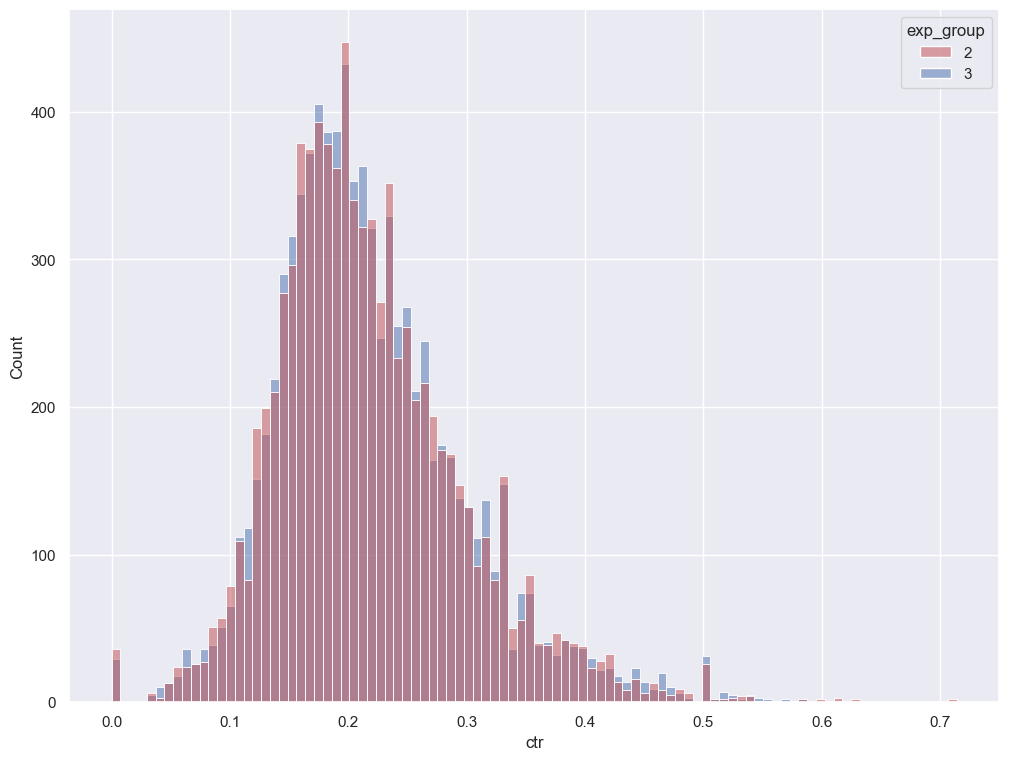

In [95]:
groups = sns.histplot(data=df,
                     x='ctr',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False)

In [96]:
stats.normaltest(df[df['exp_group'] == 2].ctr)

NormaltestResult(statistic=np.float64(1334.8989408193347), pvalue=np.float64(1.3501376613283155e-290))

In [97]:
stats.normaltest(df[df['exp_group'] == 3].ctr)

NormaltestResult(statistic=np.float64(1223.6563719492779), pvalue=np.float64(1.9337260968165916e-266))

In [98]:
# t-тест ctr
# H0 - Среднии в CTR равны

stat, p = stats.ttest_ind(df[df['exp_group'] == 2].ctr, df[df['exp_group'] == 3].ctr, equal_var=False)

if (p < 0.05):
    print(f'p-value = {round(p, 4)}. Так как p < a, то Н0 отвергается. Средние не равны.')
else:
    print(f'p-value = {round(p, 4)}. Так как p >= a (0.05), то Н0 принимается. Средние значения равны.')

p-value = 0.4597. Так как p >= a (0.05), то Н0 принимается. Средние значения равны.


In [99]:
print(stats.mannwhitneyu(df[df['exp_group'] == 2].ctr,
                         df[df['exp_group'] == 3].ctr))

print('p > 0.05')

A_gt_B = 0
for _ in range(10000):
    A_gt_B += df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
    
print(f'В {A_gt_B/100}% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=np.float64(36124728.5), pvalue=np.float64(0.5177480614337441))
p > 0.05
В 49.32% случаев A > B. Должно получиться около 50%


Два параллельных теста c 15.11 по 21.11:

**Первый**

* exp_group = 1 - Все по-старому
* exp_group = 2 - Репкомедации "похожих на лайкнутые посты"

**Второй**

* exp_group = 0 - Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

In [100]:
q = """
SELECT exp_group,
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21' and exp_group in (0, 1, 2, 3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [101]:
stats.ttest_ind(df[df.exp_group == 3].ctr,
                df[df.exp_group == 0].ctr,
                equal_var=False)

TtestResult(statistic=np.float64(13.89687072190407), pvalue=np.float64(1.0558494146624885e-43), df=np.float64(20032.623598070695))

<Axes: xlabel='ctr', ylabel='Count'>

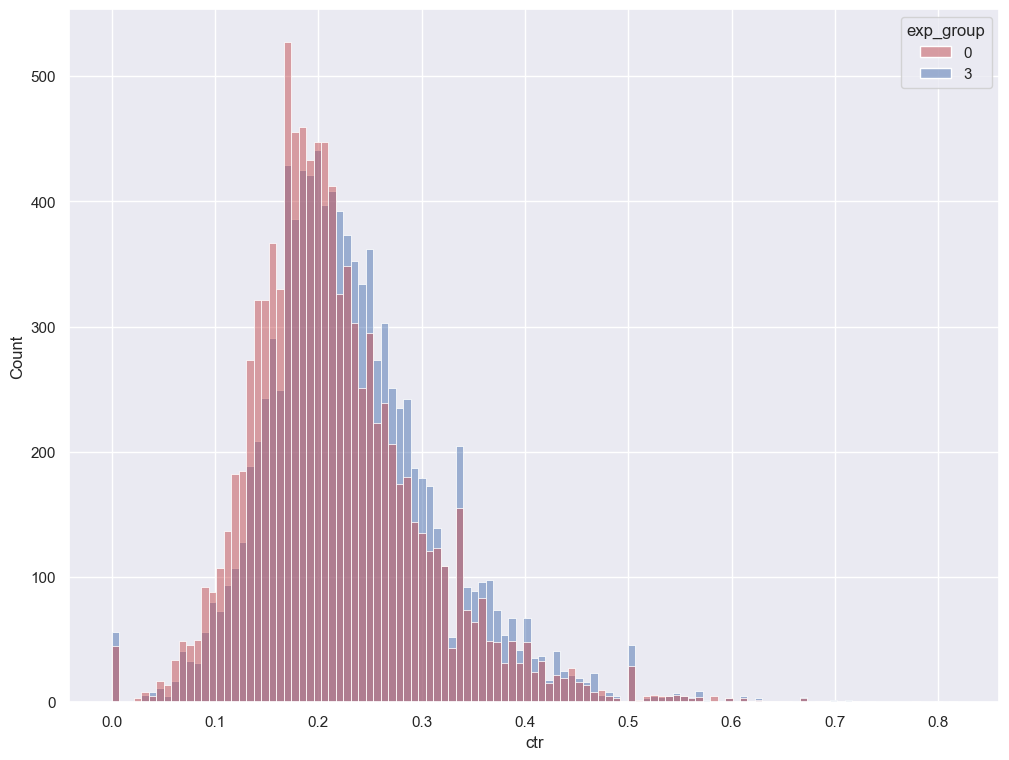

In [102]:
sns.histplot(data=df[(df['exp_group'] == 0) | (df['exp_group'] == 3)],
             x='ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)

In [103]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

TtestResult(statistic=np.float64(0.7094392041270486), pvalue=np.float64(0.4780623130874931), df=np.float64(15986.264286869278))

<Axes: xlabel='ctr', ylabel='Count'>

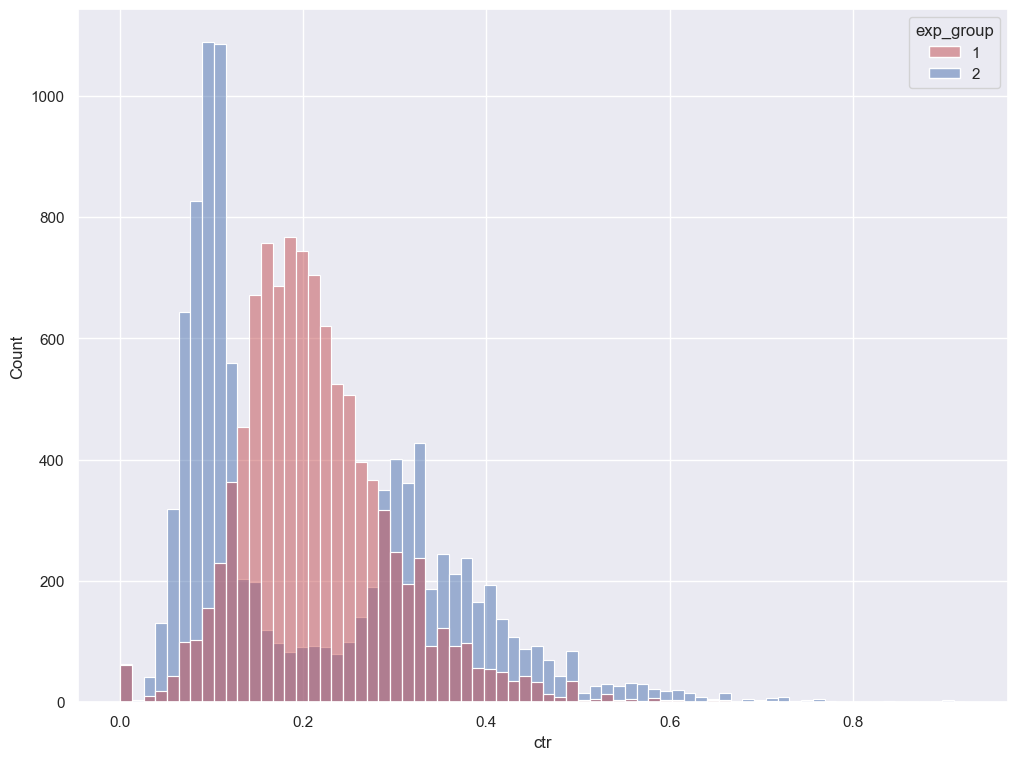

In [104]:
sns.histplot(data=df[(df['exp_group'] == 1) | (df['exp_group'] == 2)],
             x='ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)

## t-тест в Clickhouse

In [105]:
q = """
WITH welchTTest(ctr, exp_index) as ttest

SELECT tupleElement(ttest, 1) as statistic,
       tupleElement(ttest, 2) as p_value
FROM
(SELECT exp_group,
       case when exp_group = 0 then 0 else 1 end as exp_index,
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-15' AND toDate(time) <= '2021-11-21' AND exp_group in (0, 3)
GROUP BY exp_group, user_id)
"""

pandahouse.read_clickhouse(q, connection=connection)

,statistic,p_value
0,-13.896871,1.055849e-43


In [106]:
q = """
WITH welchTTest(ctr, exp_index) as ttest

SELECT tupleElement(ttest, 1) as statistic,
       tupleElement(ttest, 2) as p_value
FROM
(SELECT exp_group,
       case when exp_group = 1 then 0 else 1 end as exp_index,
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-15' AND toDate(time) <= '2021-11-21' AND exp_group in (1, 2)
GROUP BY exp_group, user_id)
"""

pandahouse.read_clickhouse(q, connection=connection)

,statistic,p_value
0,0.709439,0.478062


## Тест Манна-Уитни

In [107]:
stats.mannwhitneyu(df[df.exp_group == 0].ctr,
                   df[df.exp_group == 3].ctr, 
                   alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(43682792.0), pvalue=np.float64(1.1952055473582939e-57))

In [108]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr, 
                   alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(56601260.5), pvalue=np.float64(6.0376484617779035e-56))

## Тест Манна-Уитни в Clickhouse

In [109]:
q = """
WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw

SELECT tupleElement(mw, 1) as statistic,
       tupleElement(mw, 2) as p_value
FROM
(SELECT exp_group,
       case when exp_group = 0 then 0 else 1 end as exp_index,
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes / views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2021-11-15' AND toDate(time) <= '2021-11-21' AND exp_group in (0, 3)
GROUP BY exp_group, user_id)
"""

pandahouse.read_clickhouse(q, connection=connection)

,statistic,p_value
0,43682792.0,0.0


## Сглаженный CTR

Проблема t-теста на пользовательском CTR в том, что у нас есть пользователи с небольшим количеством просмотров, а их CTR сильно зашумлен. Мы почти ничего не знаем о CTR пользователей с 3 просмотрами, независимо от количества их кликов. Когда у пользователя есть 20 просмотров, мы можем сделать приемлемую оценку CTR этого пользователя. А если у пользователя 200 просмотров, мы можем +- точно оценить его CTR.

Сглаживание лапласа:

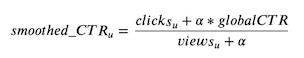

a - гиперпараметри. Идея достаточно проста: когда просмотров много, сглажекнный CTR почти равен CTR пользователя. Когда просмотров мало, сглаженный CTR почти равен общегрупповому CTR. Иначе говоря, если у пользователя много просмотров, мы можем быть уверены, что клики / просмотры - хорошая оценка его CTR, а когда у пользователя мало, мы просто устанавливаем в качестве оценки общегрупповой CTR.

Хоть идея сглаженного CTR интуитивно понятна, теоретической гарантии, что его направленность совпадает с направленностью общего количетсва кликов нет.

In [110]:
def get_smothed_ctr(likes, views, global_ctr, alpha):
    smothed_ctr = (likes + alpha * global_ctr) / (views + alpha)
    return smothed_ctr

In [111]:
q = """
SELECT 
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM 
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2021-11-15' and '2021-11-21'
GROUP BY 
    exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [112]:
df.exp_group.value_counts()

exp_group
1    10079
4    10070
3    10049
0     9999
2     9952
Name: count, dtype: int64

In [113]:
global_ctr0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
global_ctr3 = df[df.exp_group == 3].likes.sum()/df[df.exp_group == 3].views.sum()
global_ctr1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

<Axes: xlabel='ctr', ylabel='Count'>

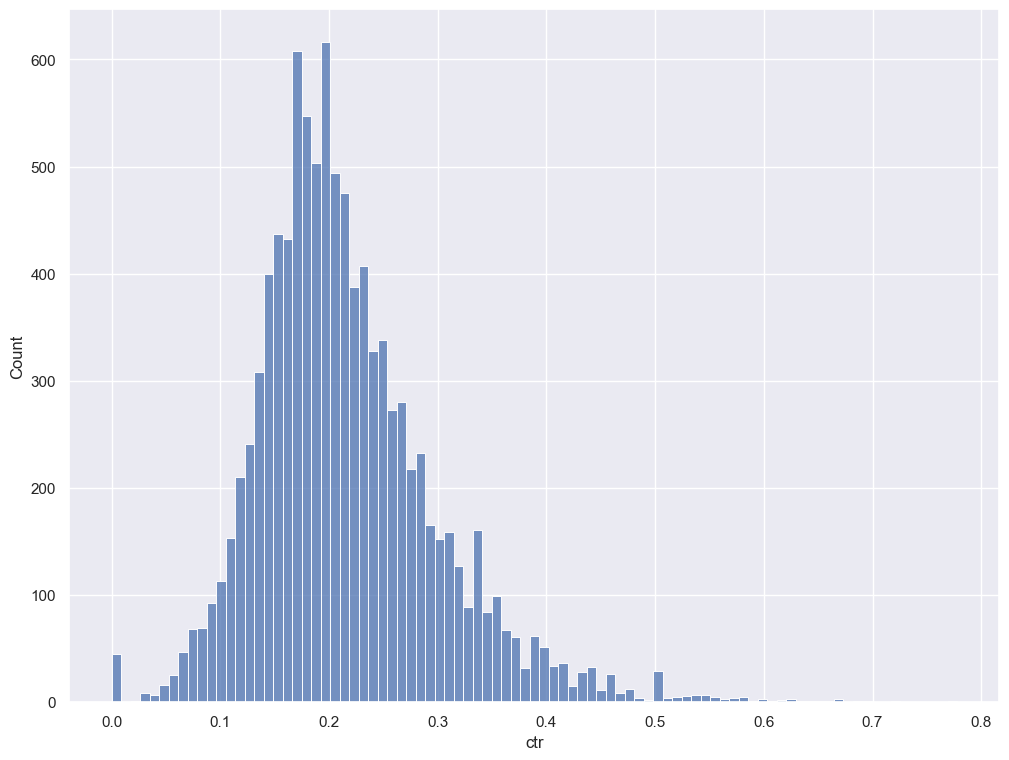

In [114]:
group_0 = df[df.exp_group == 0].copy()
sns.histplot(group_0.ctr,
             kde=False)

In [115]:
group_0['smoothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x.likes, x.views, global_ctr0, 7), axis=1)

<Axes: xlabel='smoothed_ctr', ylabel='Count'>

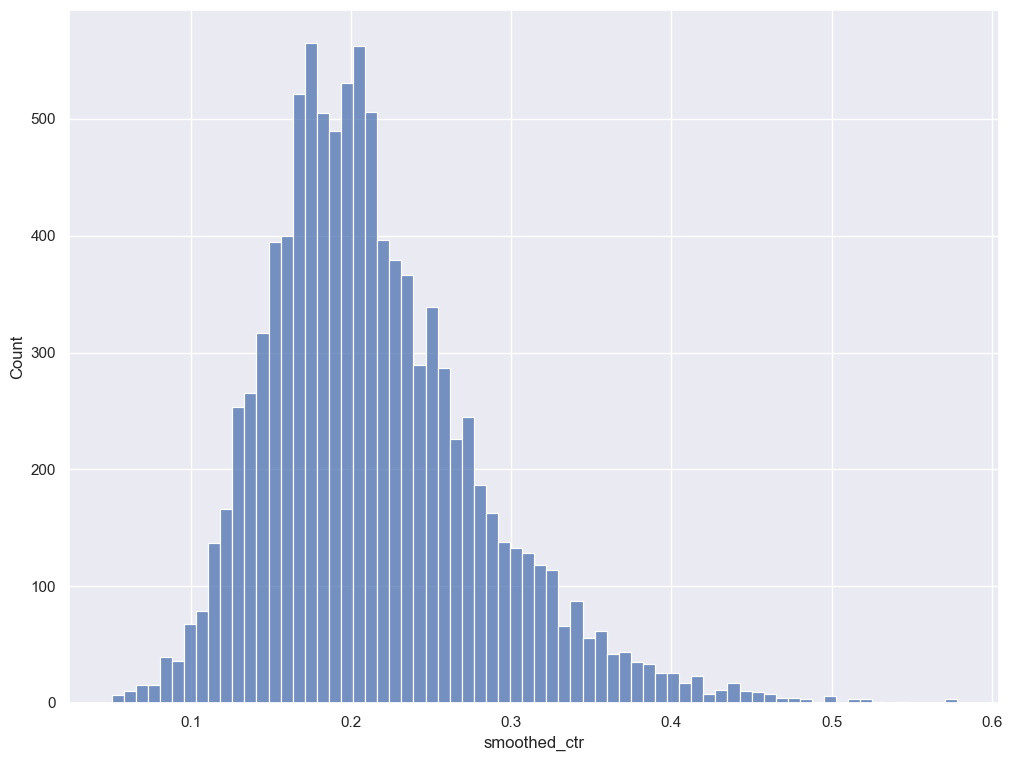

In [116]:
sns.histplot(group_0.smoothed_ctr,
             kde=False)

In [117]:
group_1 = df[df.exp_group == 1].copy()
group_2 = df[df.exp_group == 2].copy()
group_3 = df[df.exp_group == 3].copy()

<Axes: xlabel='ctr', ylabel='Count'>

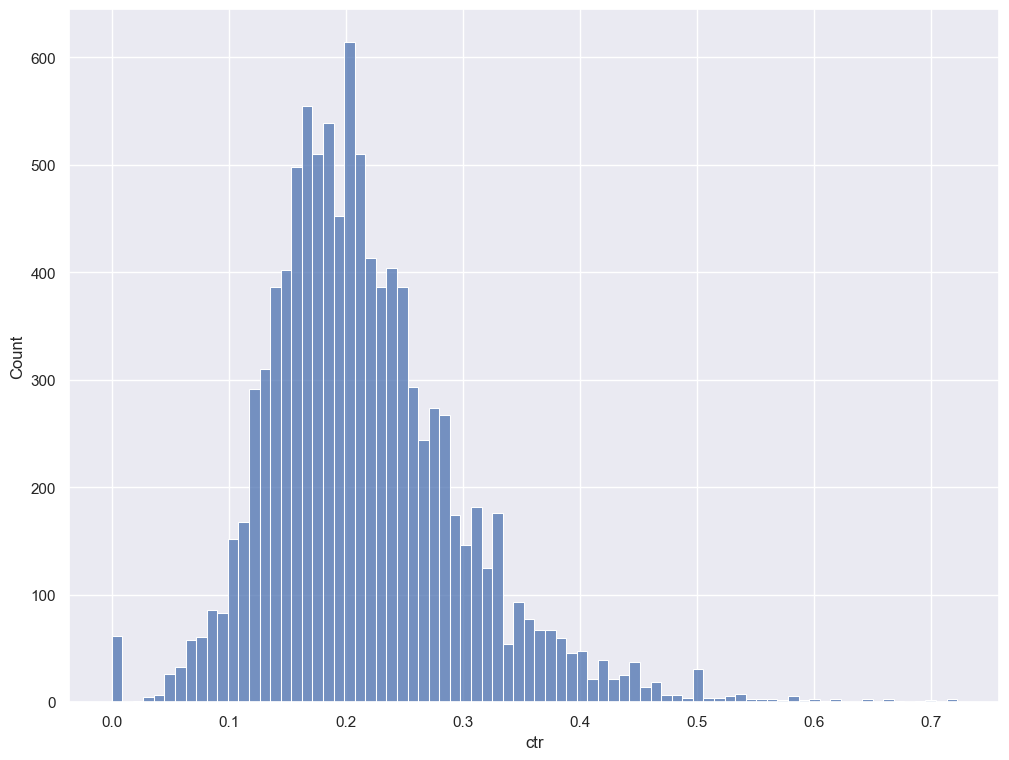

In [118]:
sns.histplot(group_1.ctr,
             kde=False)

<Axes: xlabel='ctr', ylabel='Count'>

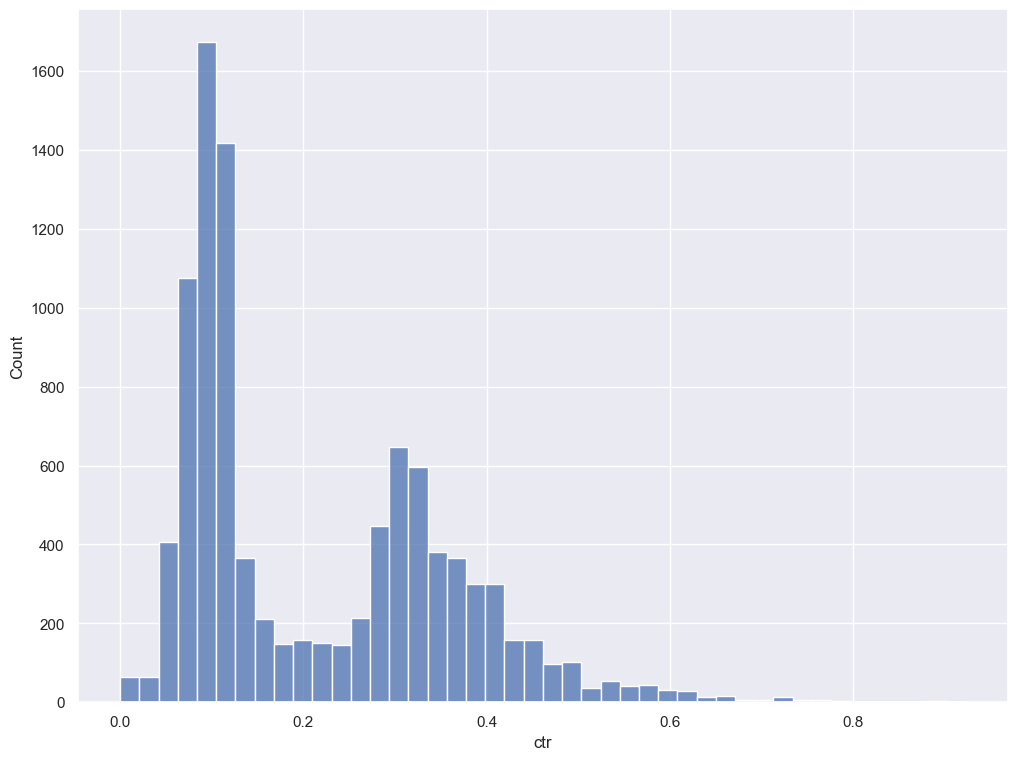

In [119]:
sns.histplot(group_2.ctr,
             kde=False)

<Axes: xlabel='ctr', ylabel='Count'>

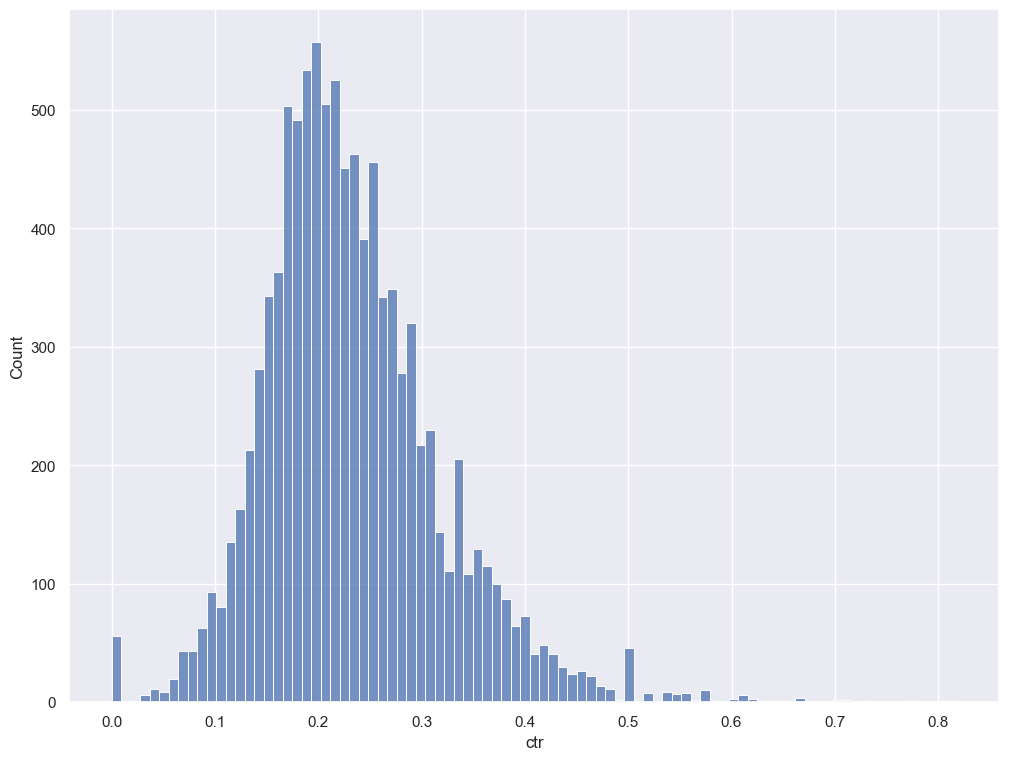

In [120]:
sns.histplot(group_3.ctr,
             kde=False)

In [121]:
group_1['smoothed_ctr'] = group_1.apply(lambda x: get_smothed_ctr(x.likes, x.views, global_ctr1, 7), axis=1)
group_2['smoothed_ctr'] = group_2.apply(lambda x: get_smothed_ctr(x.likes, x.views, global_ctr2, 7), axis=1)
group_3['smoothed_ctr'] = group_3.apply(lambda x: get_smothed_ctr(x.likes, x.views, global_ctr3, 7), axis=1)

<Axes: xlabel='smoothed_ctr', ylabel='Count'>

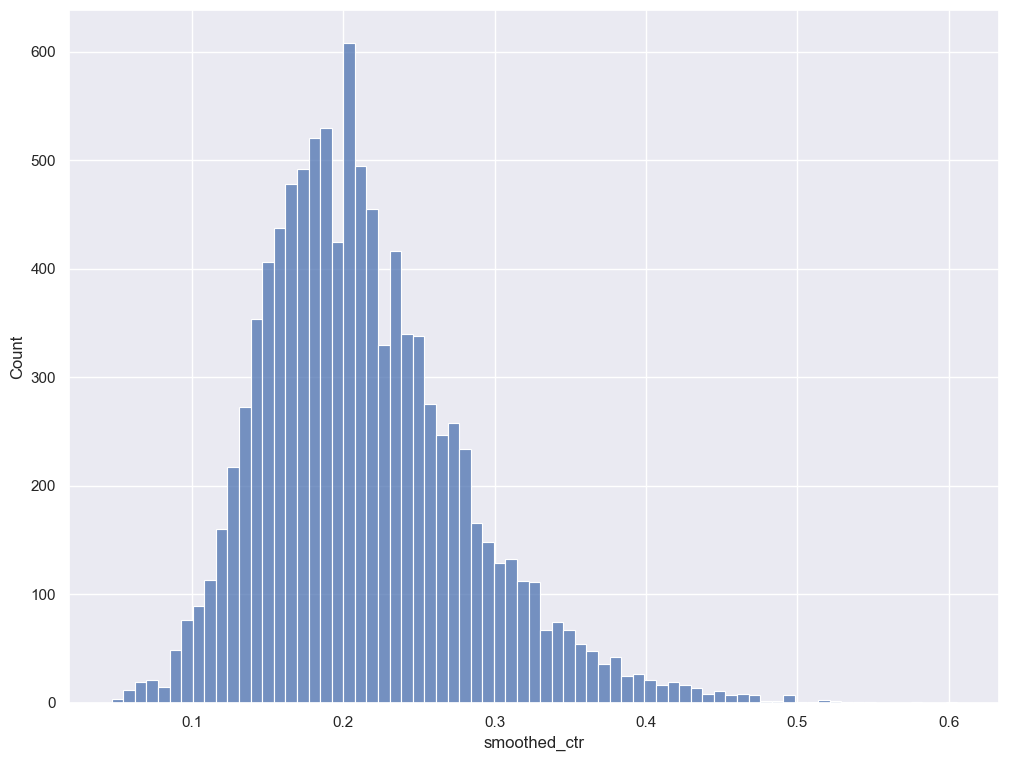

In [122]:
sns.histplot(group_1.smoothed_ctr,
             kde=False)

<Axes: xlabel='smoothed_ctr', ylabel='Count'>

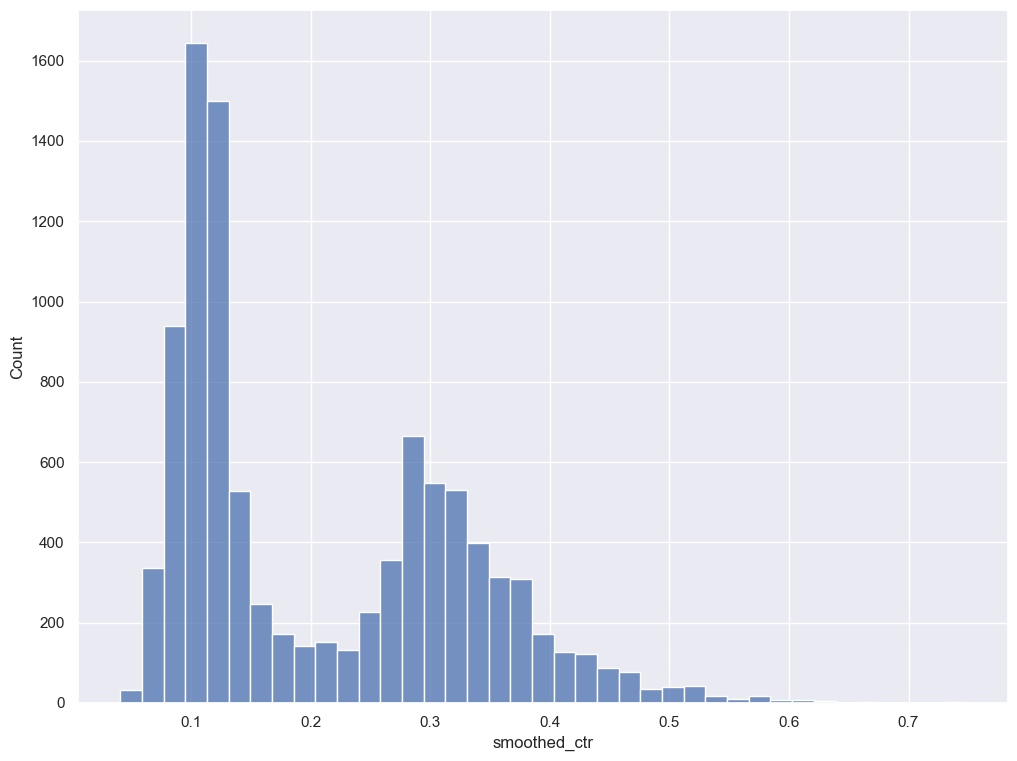

In [123]:
sns.histplot(group_2.smoothed_ctr,
             kde=False)

<Axes: xlabel='smoothed_ctr', ylabel='Count'>

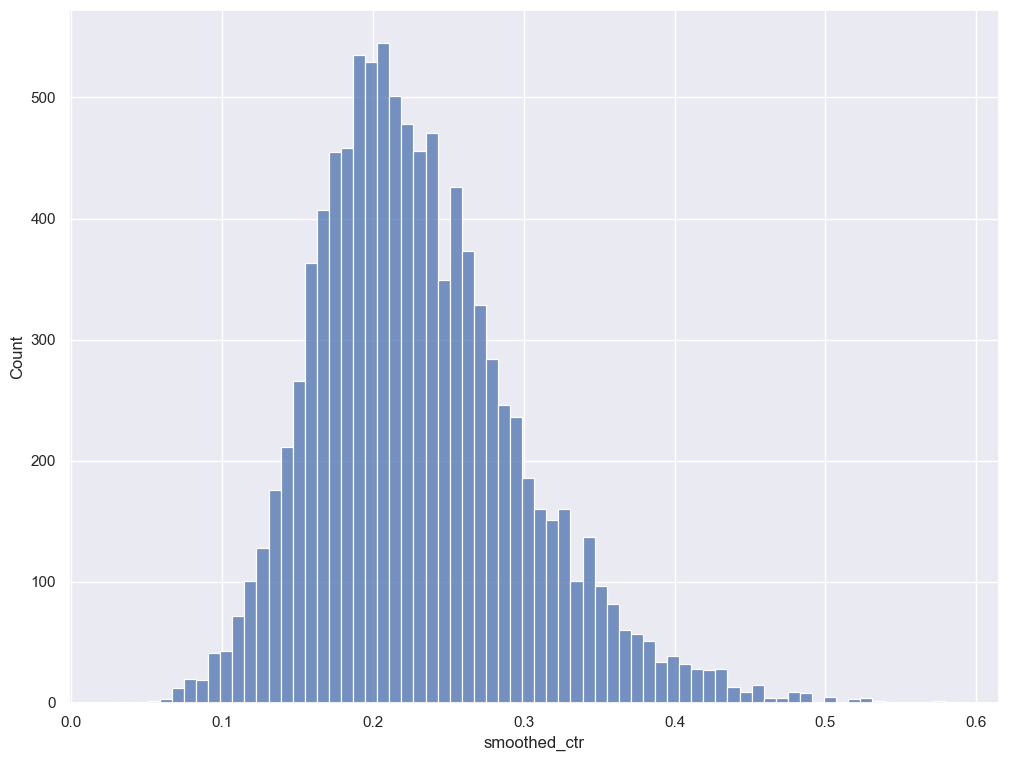

In [124]:
sns.histplot(group_3.smoothed_ctr,
             kde=False)

In [125]:
stats.ttest_ind(group_0.smoothed_ctr, group_1.smoothed_ctr, equal_var=False)

TtestResult(statistic=np.float64(0.24756338979998188), pvalue=np.float64(0.8044747714602928), df=np.float64(20075.938628628857))

In [126]:
stats.ttest_ind(group_1.smoothed_ctr, group_2.smoothed_ctr, equal_var=False)

TtestResult(statistic=np.float64(2.8113905748267034), pvalue=np.float64(0.004938885228737639), df=np.float64(15738.661073586552))

# Непараметрический bootstrap

In [127]:
def bootstrap(likes1, likes2, views1, views2, n_bootstrap=2000):
    
    poisson_bootstrap1 = stats.poisson(1).rvs(
    (2000, len(likes1))).astype(np.int64)
    
    poisson_bootstrap2 = stats.poisson(1).rvs(
    (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstrap1 * likes1).sum(axis=1) / (poisson_bootstrap1 * views1).sum(axis=1)
    globalCTR2 = ((poisson_bootstrap2 * likes2).sum(axis=1)) / ((poisson_bootstrap2 * views2).sum(axis=1))
    
    return globalCTR1, globalCTR2

In [128]:
likes1 = df[df.exp_group == 0].likes.to_numpy()
likes2 = df[df.exp_group == 3].likes.to_numpy()
views1 = df[df.exp_group == 0].views.to_numpy()
views2 = df[df.exp_group == 3].views.to_numpy()

In [129]:
global1, global2 = bootstrap(likes1, likes2, views1, views2)

<Axes: ylabel='Count'>

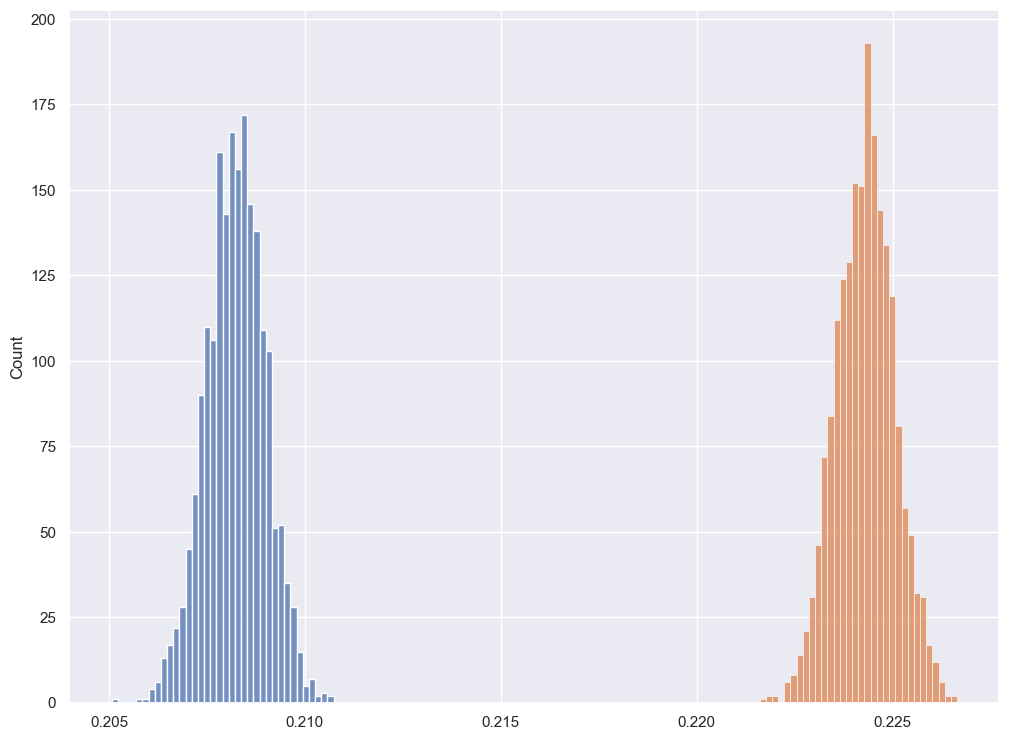

In [130]:
sns.histplot(global1)
sns.histplot(global2)

In [131]:
stats.ttest_ind(global1, global2, equal_var=False)

TtestResult(statistic=np.float64(-676.8532203506703), pvalue=np.float64(0.0), df=np.float64(3997.8699016320697))

<Axes: ylabel='Count'>

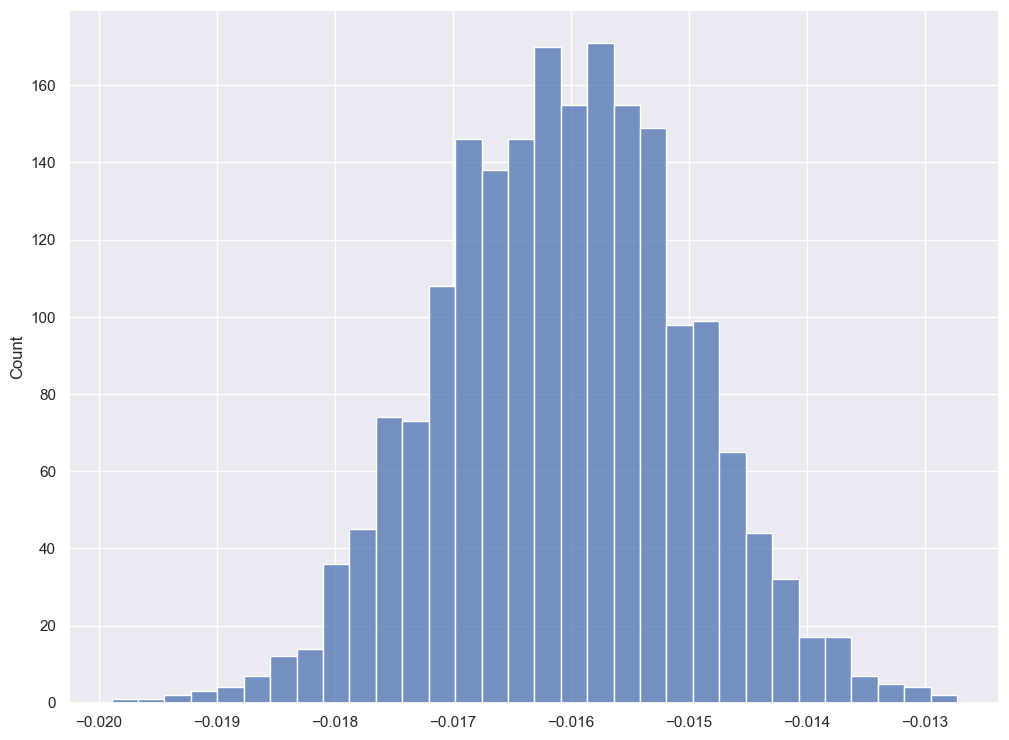

In [132]:
sns.histplot(global1 - global2)

# Бакетное преобразование 

Еще один подход, который очень часто применяется - бакетное преобразование. Надо разбить пользователей на n 'корзин' (backets). Нужно гарантировать, что каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно. Это можно гарантировать с помощью того же хеширования с солью. Каждый бакет теперь становится "метапользователем", участвующим в эксперементе. И внутри такого "метапользователя" показатели нужно как-то агрегировать.

Обычно вычисляют среднюю метрику в бакете, но можно, например, посчитать медиану или какой-то квантиль. Скеажем, если у нас 50 бакетов для теста и контроля, получается будто мы тест проводим на группах по 50 пользователей в каждой.

**В чем тут логика?**

Когда мы дели нашу исходную выборку на какое-то количество бакетов и считаем в каждом бакете, например, среднее на выходе мы получаем выборку из 50 значений среднего по этим "метопользователям". Это как будто мы сделали бустреп, но только не сгенерировав псевдовыборку, а откусив правильным образом кусок из имеющихся.

Поверк бакетного преобразованя можно, например, применить t-тест (если +- выполнены его предположения) или тест Манна-Уитни.

In [133]:
q = """
SELECT 
    exp_group,
    bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM
(SELECT exp_group,
    xxHash64(user_id)%50 as bucket,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM 
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2021-11-15' and '2021-11-21'
    AND exp_group in (0, 3)
GROUP BY 
    exp_group, bucket, user_id)
GROUP BY 
    exp_group, bucket
"""

In [134]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [135]:
df

,exp_group,bucket,bucket_ctr,ctr9
0,0,0,0.207640,0.333333
1,3,0,0.218673,0.340426
2,0,1,0.209715,0.324324
3,3,1,0.223644,0.366667
4,0,2,0.202441,0.333333
...,...,...,...,...
95,3,47,0.224819,0.342105
96,0,48,0.207802,0.329412
97,3,48,0.232450,0.366667
98,0,49,0.205913,0.325000


<Axes: xlabel='bucket_ctr', ylabel='Count'>

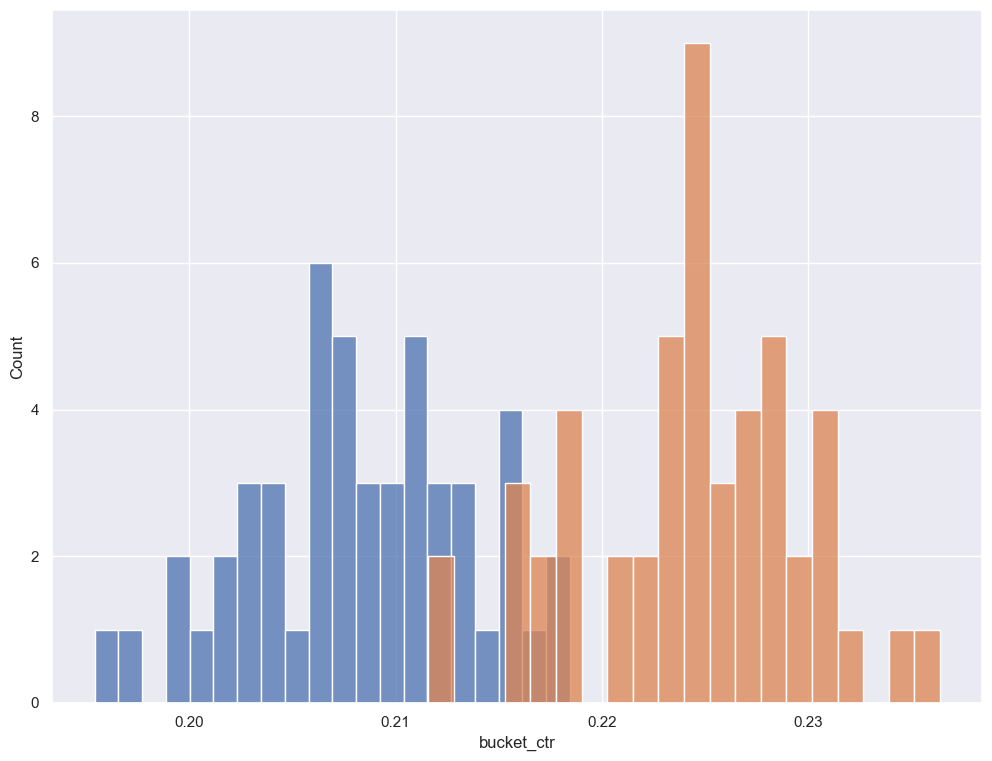

In [136]:
sns.histplot(df[df.exp_group == 0].bucket_ctr, bins=20)
sns.histplot(df[df.exp_group == 3].bucket_ctr, bins=20)

In [137]:
stats.mannwhitneyu(df[df.exp_group == 0].bucket_ctr, 
                   df[df.exp_group == 3].bucket_ctr, 
                   alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(45.0), pvalue=np.float64(1.0099815060146218e-16))

In [138]:
stats.mannwhitneyu(df[df.exp_group == 0].ctr9, 
                   df[df.exp_group == 3].ctr9, 
                   alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(474.0), pvalue=np.float64(8.307808579920587e-08))

In [139]:
q = """
SELECT 
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM 
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2025-12-26' and '2026-01-01'
    AND exp_group in (2,3)
GROUP BY 
    user_id, exp_group
"""

In [140]:
connection = {
    'host': 'http://clickhouse.lab.karpov.courses:8123',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20260120'
}

In [141]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [142]:
df

,user_id,exp_group,likes,views,ctr
0,115383,3,38,248,0.153226
1,10326,3,24,132,0.181818
2,123580,3,25,122,0.204918
3,131473,2,19,98,0.193878
4,23985,2,12,44,0.272727
...,...,...,...,...,...
16782,122008,3,20,123,0.162602
16783,25383,2,2,18,0.111111
16784,122190,3,15,56,0.267857
16785,108927,2,16,51,0.313725


In [143]:
def bootstrap(ctr_test, ctr_control, n_boot=10000):
    p_res = []
    for _ in range(0, n_boot):
        test = ctr_test.sample(500, replace=True)
        control = ctr_control.sample(500, replace=True)

        statistic, p = stats.ttest_ind(test, control, equal_var=False)
        
        p_res.append(p)
    
    return p_res

In [144]:
p_values = bootstrap(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr)

<Axes: ylabel='Count'>

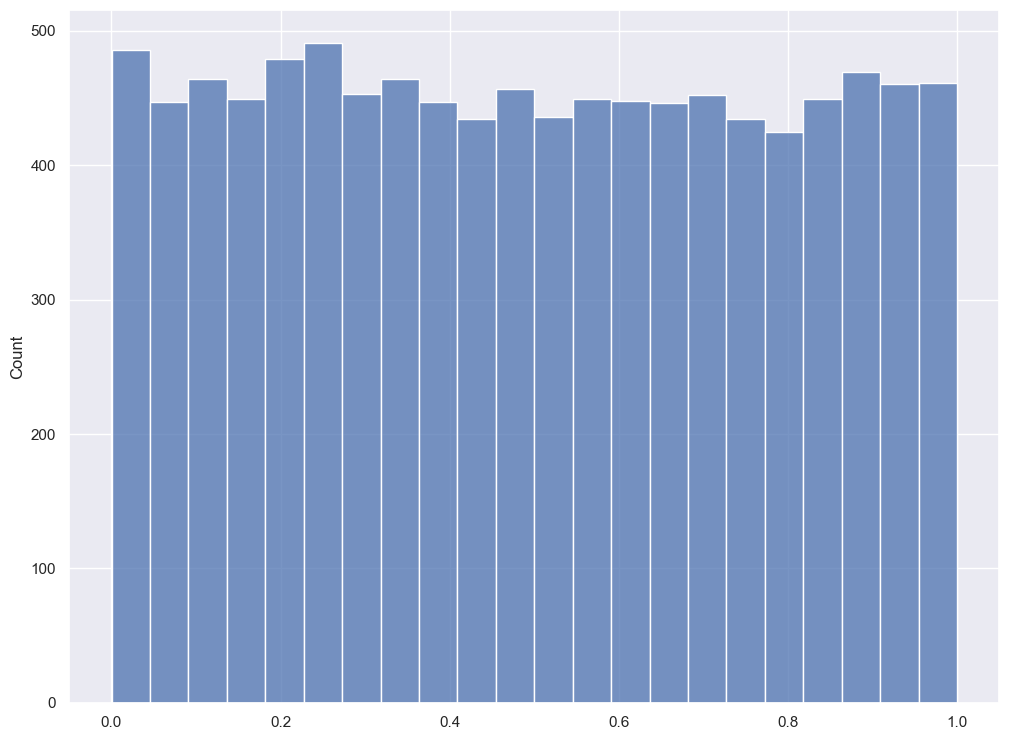

In [145]:
sns.histplot(p_values, 
             kde=False)

In [146]:
res_list = 0
for i in p_values:
    if i<0.05:
        res_list += 1
        
round(res_list/len(p_values), 4)

0.0537

## Статистический анализ

Для оценки различий между группами используется независимый двухвыборочный t-критерий.

Уровень значимости: 0.05.

Дополнительно оцениваются:
- p-value;
- доверительный интервал для разницы средних;
- практическая значимость эффекта.

Также проведем иные тесты для того, чтобы посмотреть как они работают с данными. Не будет учитываться проблема множественного сравнения, так как выводы будут сделаны на основе t-теста.

### t-тест, Mann-Whitney

In [147]:
q = """
SELECT
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2026-01-02' and '2026-01-08'
    AND exp_group in (1, 2)
GROUP BY 
    user_id, exp_group
"""

In [148]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [149]:
df.head(5)

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,39,141,0.276596
4,18392,1,7,32,0.218750


In [150]:
df.exp_group.value_counts()

exp_group
1    10020
2     9877
Name: count, dtype: int64

<Axes: xlabel='ctr', ylabel='Count'>

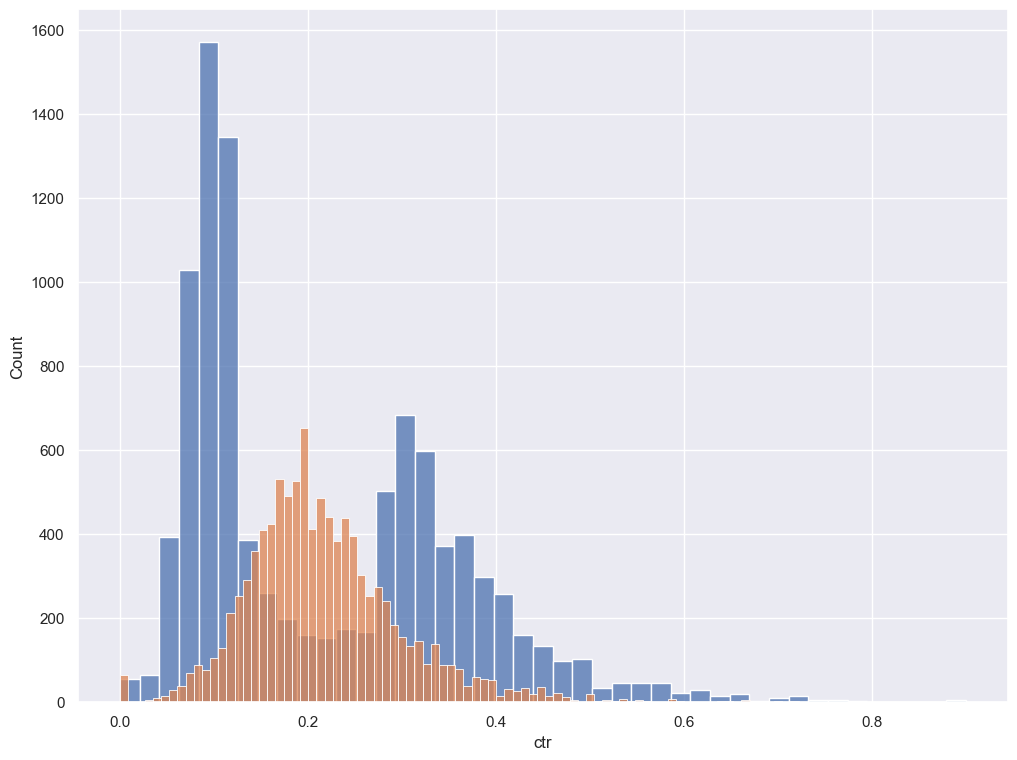

In [151]:
sns.histplot(df[df.exp_group == 2].ctr)
sns.histplot(df[df.exp_group == 1].ctr)

***Рефлексия*** 

Вообще странно, что мы в первом задании сравниваем группы 2 и 3, а во втором выбираем 2 для эксперимента. Откуда у нас информация о том, что данные группы (1 и 2) были схожи до внедрения изменений? Такое странное распределение второй группы говорит о том, что с ней что-то произошло, но дело может быть далеко не в нововведениях. Возможно, у нас получился раскол мнений о новой системе рекомендаций. Проведем t-тест и тест Манна — Уитни, но больше предпочтение отдадим бутстрапу и бакетам.

In [152]:
stats.ttest_ind(df[df.exp_group == 1].ctr, 
                df[df.exp_group == 2].ctr,
                equal_var=False)

TtestResult(statistic=np.float64(0.40514919131127564), pvalue=np.float64(0.685373331140751), df=np.float64(15811.22649797086))

In [153]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(55189913.0), pvalue=np.float64(4.632205841806026e-45))

## Пуассоновский бутстреп

In [154]:
def puasson_bootstrap(likes_1, likes_2, view_1, view_2, n_boot=2000):
    
    poisson_test = stats.poisson(1).rvs(
    (2000, len(likes_1))).astype(np.int64)
    
    poisson_control = stats.poisson(1).rvs(
    (2000, len(likes_2))).astype(np.int64)
    
    globalCTR_test = (poisson_test * likes_1).sum(axis=1) / (poisson_test * view_1).sum(axis=1)
    globalCTR_control = ((poisson_control * likes_2).sum(axis=1)) / ((poisson_control * view_2).sum(axis=1))
    
    return globalCTR_test, globalCTR_control

In [155]:
ctr_test, ctr_control = puasson_bootstrap(df[df.exp_group == 2].likes.to_numpy(), 
                                          df[df.exp_group == 1].likes.to_numpy(), 
                                          df[df.exp_group == 2].views.to_numpy(), 
                                          df[df.exp_group == 1].views.to_numpy())

<Axes: ylabel='Count'>

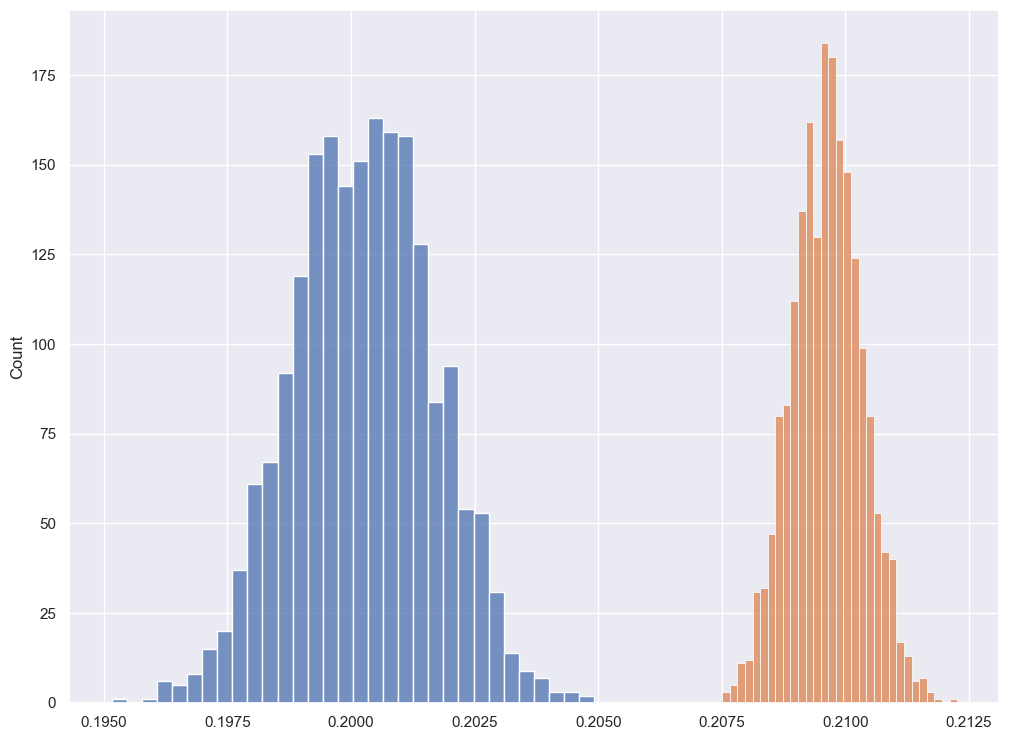

In [156]:
sns.histplot(ctr_test)
sns.histplot(ctr_control)

<Axes: ylabel='Count'>

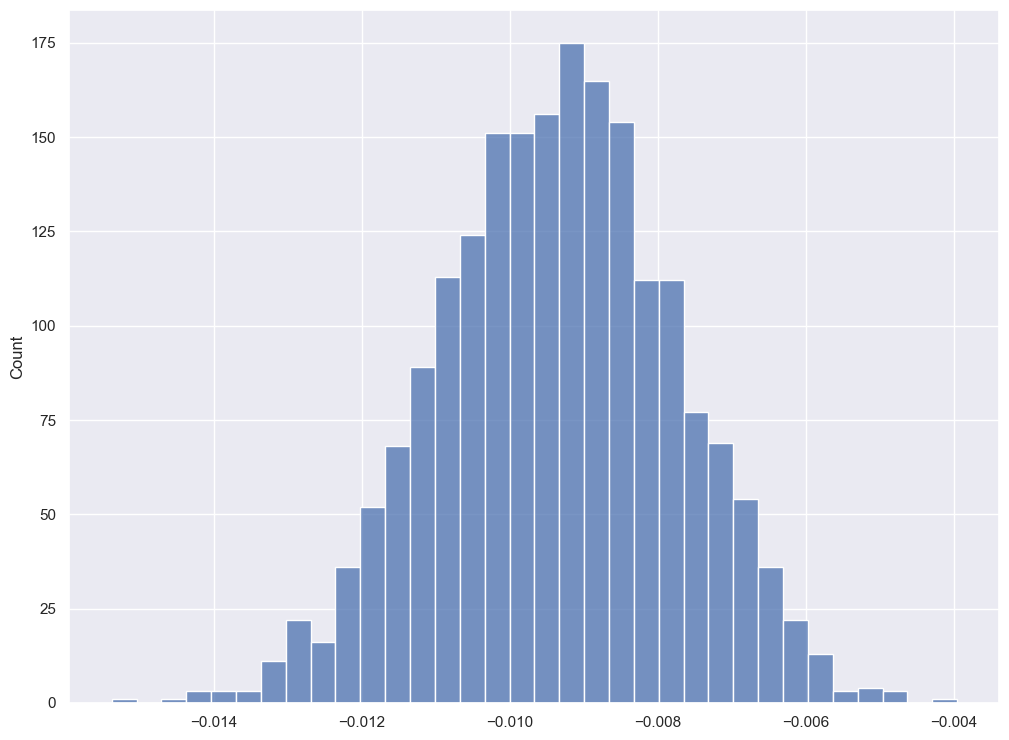

In [157]:
sns.histplot(ctr_test - ctr_control)

In [158]:
stats.ttest_ind(ctr_control, ctr_test, equal_var=False)

TtestResult(statistic=np.float64(262.7483199544694), pvalue=np.float64(0.0), df=np.float64(2943.2340820458767))

# Bucket

In [159]:
q = """
SELECT
    bucket,
    exp_group,
    sum(likes)/sum(views) as bucket_ctr
FROM
(SELECT
    xxHash64(user_id)%50 as bucket,
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2026-01-02' and '2026-01-08'
    AND exp_group in (1, 2)
GROUP BY 
    user_id,
    exp_group,
    bucket)
GROUP BY
    exp_group,
    bucket
"""

In [160]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [161]:
df

,bucket,exp_group,bucket_ctr
0,0,1,0.200592
1,0,2,0.196510
2,1,1,0.208799
3,1,2,0.210375
4,2,1,0.204632
...,...,...,...
95,47,2,0.196808
96,48,1,0.216369
97,48,2,0.194780
98,49,1,0.206288


<Axes: xlabel='bucket_ctr', ylabel='Count'>

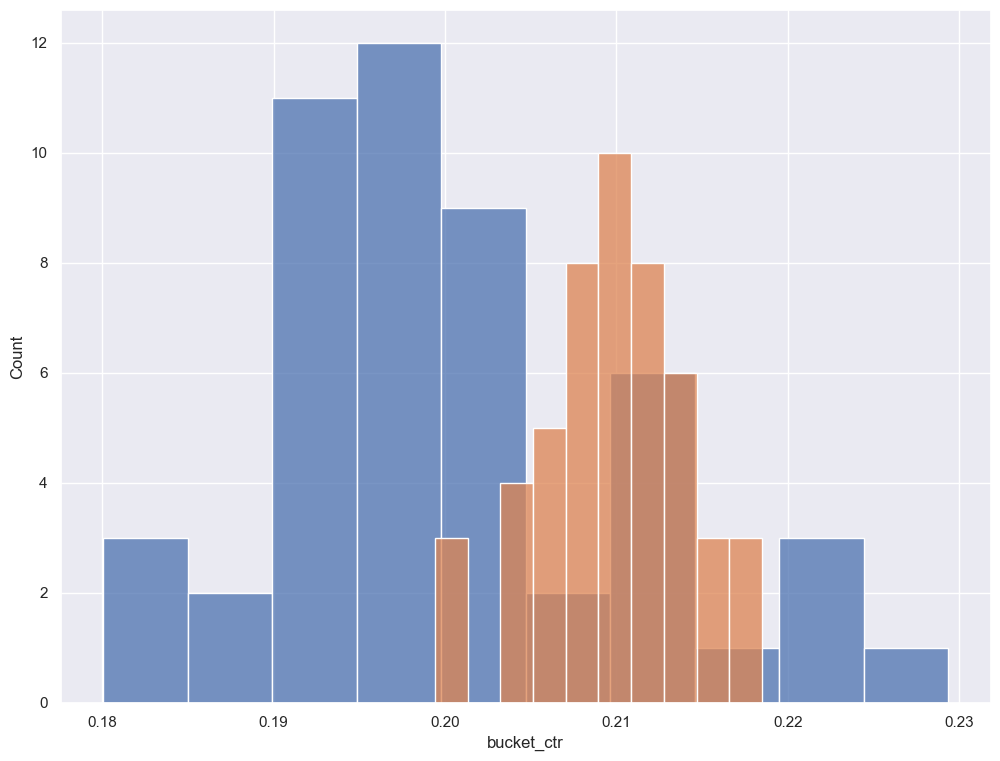

In [162]:
sns.histplot(df[df.exp_group == 2].bucket_ctr, bins=10)
sns.histplot(df[df.exp_group == 1].bucket_ctr, bins=10)

In [163]:
stats.ttest_ind(df[df.exp_group == 2].bucket_ctr, df[df.exp_group == 1].bucket_ctr, equal_var=False)

TtestResult(statistic=np.float64(-5.614819358149381), pvalue=np.float64(4.592644937473899e-07), df=np.float64(63.82788260732127))

In [164]:
stats.mannwhitneyu(df[df.exp_group == 2].bucket_ctr, df[df.exp_group == 1].bucket_ctr, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(503.0), pvalue=np.float64(2.6576427804010095e-07))

# Сглаженный CTR

In [165]:
q = """
SELECT 
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views
FROM
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2026-01-02' and '2026-01-08'
    AND exp_group in (1, 2)
GROUP BY 
    user_id,
    exp_group
"""

In [166]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [167]:
def smoothed_ctr(user_views, user_likes, global_ctr , alpha=5):
    
    smoothed_ctr = ((user_likes + alpha) * global_ctr) / (user_views + alpha)
    
    return smoothed_ctr

In [168]:
global_ctr_test = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()
global_ctr_control = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

test_group = df[df.exp_group == 2].copy()
control_group = df[df.exp_group == 1].copy()

test_group['smoothed_ctr'] = test_group.swifter.apply(lambda x: smoothed_ctr(x['views'], x['likes'], global_ctr_test), axis=1)
control_group['smoothed_ctr'] = control_group.swifter.apply(lambda x: smoothed_ctr(x['views'], x['likes'], global_ctr_control), axis=1)

sns.histplot(test_group.smoothed_ctr)
sns.histplot(control_group.smoothed_ctr)

In [169]:
stats.ttest_ind(test_group.smoothed_ctr, 
                control_group.smoothed_ctr,
                equal_var=False)

TtestResult(statistic=np.float64(-8.484565581788415), pvalue=np.float64(2.3347975948744754e-17), df=np.float64(17612.964330425657))

In [170]:
stats.mannwhitneyu(test_group.smoothed_ctr,
                   control_group.smoothed_ctr,
                   alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(42853688.0), pvalue=np.float64(3.310855203223828e-60))

## Выводы

По результатам теста получено статистически значимое различие между группами (p-value < 0.05).

Оценка величины эффекта показывает, что изменение метрики имеет практическую значимость для бизнеса.

Рекомендация: внедрить функциональность для всех пользователей.

Ограничения анализа:
- ограниченная длительность эксперимента;
- возможное влияние внешних факторов;
- отсутствие сегментационного анализа.

## AA тест второй и первой группы

In [171]:
q = """
SELECT
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) BETWEEN '2025-12-26' and '2026-01-01'
    AND exp_group in (1, 2)
GROUP BY 
    user_id,
    exp_group
"""

In [172]:
df = pandahouse.read_clickhouse(q, connection=connection)

<Axes: xlabel='ctr', ylabel='Count'>

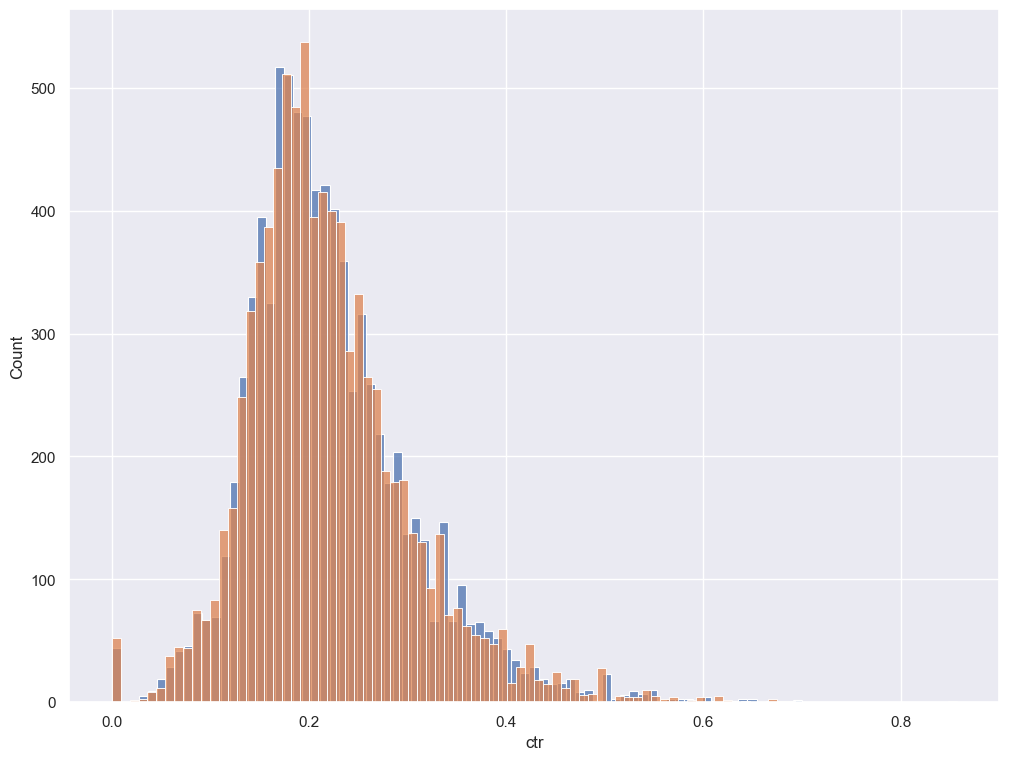

In [173]:
sns.histplot(df[df.exp_group == 2].ctr)
sns.histplot(df[df.exp_group == 1].ctr)

In [174]:
stats.ttest_ind(df[df.exp_group == 2].ctr, 
                df[df.exp_group == 1].ctr,
                equal_var=False)

TtestResult(statistic=np.float64(0.5694920635629348), pvalue=np.float64(0.5690298477939559), df=np.float64(16847.59972145556))

# Выводы по второму заданию

**Почему тесты дали такие результаты?**

Если посмотреть на распределение "сырого" ctr, то можно заметить, что среднее тестовой и контрольной будут примерно в одном месте. По-этому t-тест выдает такой результат, но это не говорит о том, что изменения отсутствуют. Тот же тест Манна-Уитни показал что разница есть, но это из-за способа проверки гипотез. 

**Когда такое могло произойти?**

Изначально мне показалось, что это ловушка от авторов задания, но проведя АА тест выборок выяснилось, что до внедрения изменений группы вели себя одинаково. Мое преположение в том, что способ внедренный ML специалистами не учитывает другие факторы, по которым нужно сегментировать пользователей. В случайных выборках могут попадать пользователи, у которых:
1. Мало друзей. Система сплитования на них работает хуже, что и приводит к уменьшению CTR у части пользователей.
2. Мало пабликов. Ошибка такая же как и в первом случае.

Часть пользователей ощутила на себе эффект, другая нет, но исходя из разных стат.тестов (без поправок на множественное сравнение), у нас эффект не покрасился только в 1 тесте.

**Рекомендация**

После всех стат тестов можно сказать, что эффект, полученный в результате тестирования, работает только на части пользователей, а другую часть откидывает назад (уменьшение ключевой метрики) и таких пользователей гораздо больше. 

Список рекомендаций:
1. При следующих тестированиях доработать систему сплитования, если будут проводиться эксперементы по взаимосвязи пользователя А и пользователя Б (также как и подписки А и подписки Б, просмотренные видио А и просмотренные видео Б и т.п.).
2. Данные изменения не нужно выкатывать для всех пользователей, потому что наблюдаемый эффект негативно сказывается на ключевой метрике.

# Задание 4

Суть линеаризации:

1. Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
2. Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
3. После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [175]:
q = """
SELECT
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) BETWEEN '2026-01-02' and '2026-01-08'
    AND exp_group in (0, 3)
GROUP BY 
    user_id, exp_group
"""

In [176]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [177]:
globalCTR = round(df.likes.sum()/df.views.sum(), 2)
globalCTR

np.float64(0.22)

In [178]:
df['linearized_likes'] = df.swifter.apply(lambda x: x.likes-(globalCTR*x.views), axis=1)

In [179]:
df

,user_id,exp_group,likes,views,ctr,linearized_likes
0,115383,3,12,44,0.272727,2.32
1,123580,3,2,11,0.181818,-0.42
2,4944,0,8,41,0.195122,-1.02
3,4504,0,5,15,0.333333,1.70
4,121508,0,6,25,0.240000,0.50
...,...,...,...,...,...,...
19917,13781,3,10,27,0.370370,4.06
19918,130651,3,18,98,0.183673,-3.56
19919,3681,0,7,55,0.127273,-5.10
19920,122008,3,5,41,0.121951,-4.02


In [180]:
stats.ttest_ind(df[df.exp_group == 0].linearized_likes, 
                df[df.exp_group == 3].linearized_likes, 
                equal_var=False)

TtestResult(statistic=np.float64(-16.093706783812102), pvalue=np.float64(6.554939926429877e-58), df=np.float64(19899.027106673897))

In [181]:
stats.ttest_ind(df[df.exp_group == 0].ctr, 
                df[df.exp_group == 3].ctr, 
                equal_var=False)

TtestResult(statistic=np.float64(-13.935320516755773), pvalue=np.float64(6.216047483062214e-44), df=np.float64(19911.289778579154))

In [182]:
q = """
SELECT
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) BETWEEN '2026-01-02' and '2026-01-08'
    AND exp_group in (1, 2)
GROUP BY 
    user_id, exp_group
"""

df = pandahouse.read_clickhouse(q, connection=connection)

globalCTR = round(df.likes.sum()/df.views.sum(), 2)

df['linearized_likes'] = df.swifter.apply(lambda x: x.likes-(globalCTR*x.views), axis=1)

df

,user_id,exp_group,likes,views,ctr,linearized_likes
0,109963,1,3,15,0.200000,0.0
1,26117,1,32,141,0.226950,3.8
2,138232,1,18,73,0.246575,3.4
3,26295,1,39,141,0.276596,10.8
4,18392,1,7,32,0.218750,0.6
...,...,...,...,...,...,...
19892,17146,2,0,10,0.000000,-2.0
19893,30872,1,11,59,0.186441,-0.8
19894,25383,2,42,127,0.330709,16.6
19895,139020,2,17,41,0.414634,8.8


In [183]:
stats.ttest_ind(df[df.exp_group == 1].linearized_likes, 
                df[df.exp_group == 2].linearized_likes, 
                equal_var=False).pvalue

np.float64(2.040570020561656e-09)

In [184]:
stats.ttest_ind(df[df.exp_group == 1].ctr, 
                df[df.exp_group == 2].ctr, 
                equal_var=False).pvalue

np.float64(0.685373331140751)